In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../')
from utilities.ML_algorithms import create_RF_model, create_XGB_model, create_ANN_model
from utilities.plot_results import plot_prediction, plot_scores, plot_feature_importance

In [3]:
cs_file = '../data/SMB_input_belli_ERA5.csv'

df_test = pd.read_csv(cs_file, delimiter='\t', index_col=['Date'], parse_dates=['Date'], na_values='NAN')

cs_file = '../data/SMB_input_four_ERA5.csv'

df_train = pd.read_csv(cs_file, delimiter='\t', index_col=['Date'], parse_dates=['Date'], na_values='NAN')


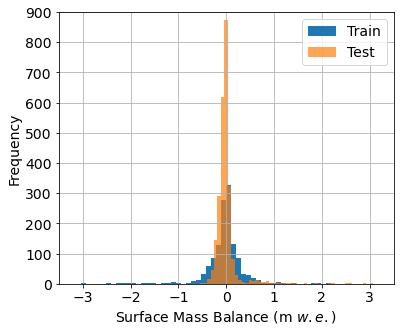

In [4]:
fig, (ax) = plt.subplots(1,1 ,figsize=(6,5))
df_train['SMB'].hist(ax=ax, bins=50, label='Train')
df_test['SMB'].hist(ax=ax, bins=50, label='Test', alpha=0.7)
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(0, 900)
ax.set_xlabel('Surface Mass Balance (m $w.e.$)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)


In [8]:
df_train.reset_index(inplace=True)
df_train = df_train.sort_values(by = ['Elevation', 'Date'], ascending=True)
df_test  = df_test.sort_values(by = ['Elevation', 'Date'], ascending=True)

In [6]:
label_stake = df_train.drop_duplicates(subset=['Elevation']).reset_index()[['Elevation', 'Stake']]
label_stake

,Elevation,Stake
0,96.8,PG19
1,121.0,PG09
2,131.4,PG18
3,159.1,PG08
4,167.2,PG17
5,188.6,PG07
6,194.5,PG16_AWS
7,223.7,PG06
8,229.4,PG16
9,247.9,PG05


In [9]:
label_stake_test = df_test.drop_duplicates(subset=['Elevation']).reset_index()[['Elevation', 'Stake']]
label_stake_test

,Elevation,Stake
0,54.0,R15
1,82.0,R1
2,84.0,R13
3,88.0,DN
4,91.0,6N
5,96.0,R1А
6,108.0,EN
7,110.0,CN
8,116.0,R2
9,135.0,R3


In [6]:
df_train.index = df_train['Stake']

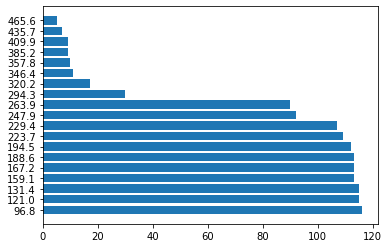

In [7]:
fig, ax = plt.subplots()
ax.barh(label_stake.index, df_train.index.value_counts().values)
ax.set_yticks(label_stake.index)
ax.set_yticklabels(label_stake['Elevation'])
print()

In [69]:
n_folds = 10
prng = np.random.RandomState(1)
random_stake1 = prng.randint(0, len(label_stake), n_folds) # Random glacier indexes
prng = np.random.RandomState(2021)
random_stake2 = prng.randint(0, len(label_stake), n_folds) # Random glacier indexes
prng = np.random.RandomState(2022)
random_stake3 = prng.randint(0, len(label_stake), n_folds) # Random glacier indexes

index_test = np.stack((random_stake1, random_stake2, random_stake3), axis=1)
index_test

array([[ 5,  0, 13],
       [11, 13, 16],
       [12, 12, 17],
       [ 8, 12, 17],
       [ 9,  6, 16],
       [11,  6, 18],
       [ 5,  6, 16],
       [15,  1,  9],
       [ 0,  5,  1],
       [16,  7, 11]])

In [20]:
data_train_df = df_train.loc[label_stake.drop(index_test[0])['Stake'].values]
data_test_df  = df_train.loc[label_stake.loc[index_test[0]]['Stake'].values]

data_train_df.dropna(inplace=True)
data_test_df.dropna(inplace=True)

features_to_drop = ['Date', 'Stake', 'Latitude','Longitude', 'SMB']

df_train_X = (data_train_df.drop(features_to_drop, axis=1)) 
X_train = (data_train_df.drop(features_to_drop, axis=1)).to_numpy()
y_train = (data_train_df['SMB'].copy()).to_numpy()
X_test  = (data_test_df.drop(features_to_drop, axis=1)).to_numpy()
y_test  = (data_test_df['SMB'].copy()).to_numpy()
print('Train:'+ ' ' + str(len(X_train)))
print('Test:'+ ' ' + str(len(X_test)))
XGB_model = create_XGB_model()
model = XGB_model.fit(X_train, y_train)
test_scores = model.cv_results_['mean_test_score']
train_scores = model.cv_results_['mean_train_score'] 


Train: 1055
Test: 238


In [ ]:
folder_work   = '../XGB/LOSO_ERA5/NORMAL'
path_xgb      = folder_work + '/CV/'
path_xgb_fig  = folder_work + '/CV_FIG/'
path_xgb_figs = folder_work + '/CV_Scatter/'
path_xgb_figf = folder_work + '/CV_feature_imp/'

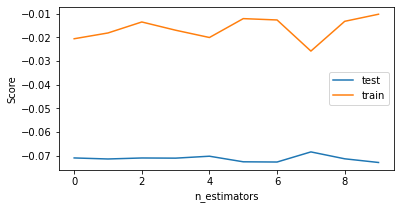

In [21]:
j = 0
fig = plot_scores(test_scores, train_scores)
fig.savefig(path_xgb_fig + str(j+1) + '_score_XGB_stakes.png',dpi = 150,
bbox_inches = 'tight',pad_inches = 0.1, facecolor='w')


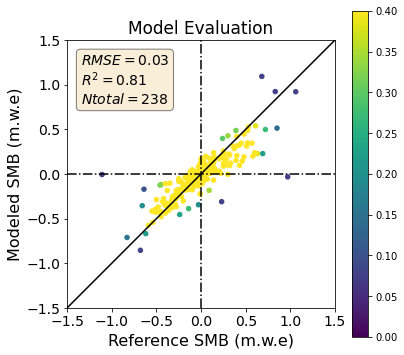

In [23]:
fig = plot_prediction(y_test, XGB_model.predict(X_test), len(y_test), n_toplot=5000 )
#fig = plot_prediction(y_train, XGB_model.predict(X_train), n_toplot=5000)
fig.savefig(path_xgb_figs + str(j+1) + '_scatter_XGB_stakes.png',dpi = 150,
bbox_inches = 'tight',pad_inches = 0.1, facecolor='w')


In [24]:
df_train_X = (data_train_df.drop(features_to_drop, axis=1))


In [25]:
XGB_model.best_params_

{'n_estimators': 300,
 'min_samples_leaf': 30,
 'max_features': 2,
 'max_depth': 6}

In [ ]:
import os

In [ ]:
dir_ann = '../XGB/LOSO_ERA5/GROUP/CV/'
models = sorted(os.listdir(dir_ann))


<Figure size 432x216 with 0 Axes>

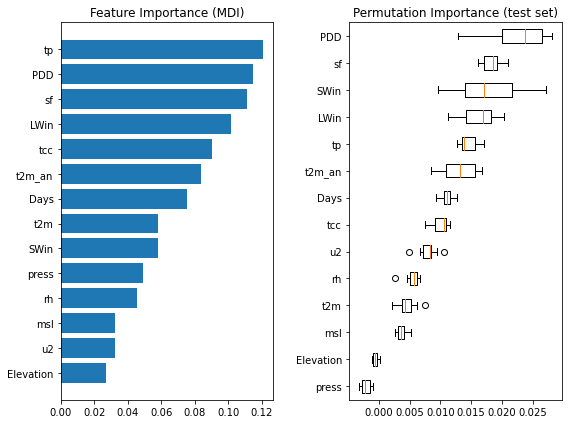

In [26]:
fig = plot_feature_importance(XGB_model, df_train_X, X_test, y_test)
fig.savefig(path_xgb_figf + str(j+1) + '_feature_XGB_stakes.png',dpi = 150,
bbox_inches = 'tight',pad_inches = 0.1, facecolor='w')